In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras import Model
import time

In [2]:
from cvae import CVAE, optimizer, log_normal_pdf, compute_loss, train_step

## MNIST dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)

In [5]:
train_size = x_train.shape[0] # = 60000
batch_size = 32
test_size = x_test.shape[0] # = 10000
label_size = 10

In [6]:
train_dataset_x = tf.data.Dataset.from_tensor_slices(x_train)
test_dataset_x = tf.data.Dataset.from_tensor_slices(x_test)
print(train_dataset_x, test_dataset_x)

<TensorSliceDataset shapes: (28, 28, 1), types: tf.float32> <TensorSliceDataset shapes: (28, 28, 1), types: tf.float32>


In [7]:
train_dataset_y= tf.data.Dataset.from_tensor_slices(y_train)
test_dataset_y = tf.data.Dataset.from_tensor_slices(y_test)
print(train_dataset_y, test_dataset_y)

<TensorSliceDataset shapes: (), types: tf.uint8> <TensorSliceDataset shapes: (), types: tf.uint8>


### make (image, label) pair

In [8]:
train_dataset_xy = tf.data.Dataset.zip((train_dataset_x, train_dataset_y))
train_dataset_xy = train_dataset_xy.shuffle(train_size).batch(batch_size)
test_dataset_xy = tf.data.Dataset.zip((test_dataset_x, test_dataset_y))
test_dataset_xy = test_dataset_xy.shuffle(train_size).batch(batch_size)
print(train_dataset_xy, test_dataset_xy)

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)> <BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)>


## モデル準備（manifoldのためlatent_dimは2次元）

In [9]:
epochs = 50
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

In [10]:
model = CVAE(latent_dim, label_size)
print(model.encoder.summary())
print('')
print(model.decoder.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 32)        3200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 9220      
Total params: 30,916
Trainable params: 30,916
Non-trainable params: 0
_________________________________________________________________
None

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1568)              20384     
________________________

## 学習

In [11]:
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train in train_dataset_xy:
    train_step(model, train, optimizer)
  end_time = time.time()

  loss_tr = tf.keras.metrics.Mean()
  for train in train_dataset_xy:
    loss_tr(compute_loss(model, train))
  elbo_tr = -loss_tr.result()

  loss_tst = tf.keras.metrics.Mean()
  for test in test_dataset_xy:
    loss_tst(compute_loss(model, test))
  elbo_tst = -loss_tst.result()
  print(f'Epoch: {epoch}, Train set ELBO: {elbo_tr}, Test set ELBO: {elbo_tst}, time elapse for current epoch: {end_time - start_time}')

Epoch: 1, Train set ELBO: -154.24331665039062, Test set ELBO: -154.31517028808594, time elapse for current epoch: 5.692764043807983
Epoch: 2, Train set ELBO: -135.73092651367188, Test set ELBO: -135.53927612304688, time elapse for current epoch: 4.416714429855347
Epoch: 3, Train set ELBO: -132.27920532226562, Test set ELBO: -132.18605041503906, time elapse for current epoch: 4.402353525161743
Epoch: 4, Train set ELBO: -130.61839294433594, Test set ELBO: -130.51568603515625, time elapse for current epoch: 4.407780885696411
Epoch: 5, Train set ELBO: -129.36773681640625, Test set ELBO: -129.43792724609375, time elapse for current epoch: 4.281843185424805
Epoch: 6, Train set ELBO: -128.61883544921875, Test set ELBO: -128.81016540527344, time elapse for current epoch: 4.28105902671814
Epoch: 7, Train set ELBO: -127.97877502441406, Test set ELBO: -128.18988037109375, time elapse for current epoch: 4.2578911781311035
Epoch: 8, Train set ELBO: -127.45867156982422, Test set ELBO: -127.645675659

## Display a 2D manifold

In [20]:
def plot_latent_images(model, label, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z, label)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

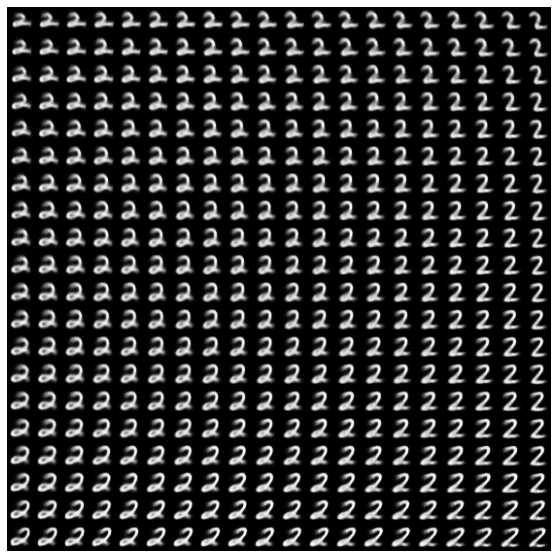

In [21]:
plot_latent_images(model, 2, 20)

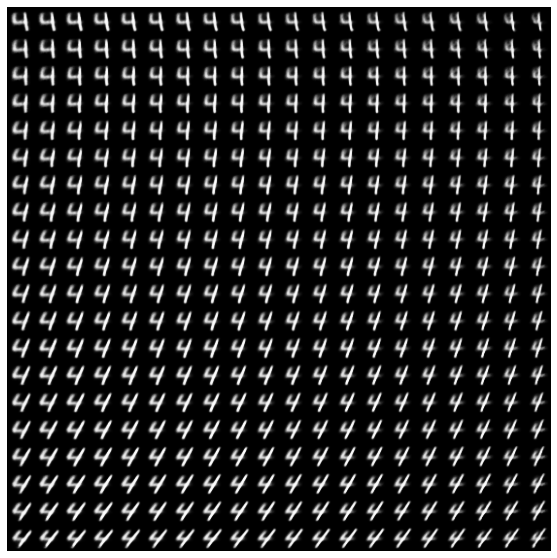

In [22]:
plot_latent_images(model, 4, 20)